In [1]:
# импортируем нужные библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
plt.rcParams["figure.figsize"] = (10.0, 7.0)

In [2]:
# Загрузим имеющиеся данные в датафреймы

ABgroup = pd.read_csv('ABgroup.csv', sep=',')
cash = pd.read_csv('Cash.csv', sep=',', parse_dates=['date'], dayfirst=True)
money = pd.read_csv('Money.csv', sep=',', parse_dates=['date'], dayfirst=True)
cheaters = pd.read_csv('Cheaters.csv', sep=',')
platforms = pd.read_csv('Platforms.csv', sep=',')

In [3]:
# так как имеются дубликаты, удалим их в датасетах где нет разбивки по дате

ABgroup.drop_duplicates(inplace=True)
cheaters.drop_duplicates(inplace=True)
platforms.drop_duplicates(inplace=True)

### Раздел 3. Очистка данных

In [4]:
# создатим датафрейм с существующими читерами

cheaters_true = cheaters[cheaters['cheaters'] == 1]

In [5]:
# создадим общий датафрейм по читерам и их тратами и платежами

cheaters_payments = cash.merge(cheaters_true, on='user_id').merge(money, on = ['user_id', 'date'])

In [6]:
cheaters_payments.describe()

,cash,cheaters,money
count,2824.000000,2824.0,2824.0
mean,18350.991501,1.0,0.0
std,16069.479162,0.0,0.0
min,0.000000,1.0,0.0
25%,5200.000000,1.0,0.0
50%,16200.000000,1.0,0.0
75%,28600.000000,1.0,0.0
max,148200.000000,1.0,0.0


In [7]:
# будем смотреть сразу на суммарные цифры за период

cheaters_payments.groupby('user_id').agg('sum').describe()

,cash,cheaters,money
count,353.000000,353.0,353.0
mean,146807.932011,8.0,0.0
std,33800.925081,0.0,0.0
min,46700.000000,8.0,0.0
25%,125100.000000,8.0,0.0
50%,147200.000000,8.0,0.0
75%,169700.000000,8.0,0.0
max,253150.000000,8.0,0.0


Видим, что читеры вообще не производят платежей (донатов)

In [8]:
# Теперь посмотрим на обычных игроков.

players = cheaters[cheaters['cheaters'] == 0]
players_payment = cash.merge(players, on='user_id').merge(money, on = ['user_id', 'date'])

In [9]:
players_payment.describe()

,cash,cheaters,money
count,8.637176e+06,8637176.0,8.637176e+06
mean,7.576511e+02,0.0,7.492327e-01
std,7.716610e+02,0.0,7.923057e-01
min,0.000000e+00,0.0,0.000000e+00
25%,2.500000e+02,0.0,0.000000e+00
50%,7.000000e+02,0.0,9.900000e-01
75%,1.150000e+03,0.0,9.900000e-01
max,1.377500e+05,0.0,9.990000e+00


In [10]:
# Сделаем менее научный формат

pd.options.display.float_format = '{:,.1f}'.format

In [11]:
players_payment.groupby('user_id').agg('sum').describe()

,cash,cheaters,money
count,"1,079,647.0","1,079,647.0","1,079,647.0"
mean,"6,061.2",0.0,6.0
std,"3,004.2",0.0,1.9
min,50.0,0.0,0.0
25%,"5,050.0",0.0,5.0
50%,"6,000.0",0.0,6.0
75%,"6,950.0",0.0,7.0
max,"240,950.0",0.0,16.9


In [12]:
# посмотрим также на медианы

print(cheaters_payments.groupby('user_id').agg('sum').median())
print(players_payment.groupby('user_id').agg('sum').median())

cash       147,200.0
cheaters         8.0
money            0.0
dtype: float64
cash       6,000.0
cheaters       0.0
money          6.0
dtype: float64


Видно что траты обычных игроков и читеров разнятся в десятки раз. При этом читеры не покупают валюту.

Найдем всех кто потратил больше 95 квантиля по обычным игрокам и при этом не платил за валюту.

In [13]:
player_level_95 = np.percentile(players_payment.groupby('user_id').agg('sum').cash, 95)

In [14]:
allpeiod_player = players_payment.groupby('user_id').agg('sum')

In [15]:
suspicious_player = allpeiod_player[(allpeiod_player['cash'] > player_level_95) & (allpeiod_player['money'] == 0)]

In [16]:
suspicious_player

,cash,cheaters,money
user_id,,,
027YD0-7N2S50,203400,0,0.0
091QZN-XYWQ8D,78500,0,0.0
0E95BB-LTAHXQ,166000,0,0.0
0GCX0G-5BZ6HE,122650,0,0.0
0GH23F-XS6VSB,152150,0,0.0
...,...,...,...
ZQNX2R-TGBYZ0,147200,0,0.0
ZRQNJL-5G1WXO,97950,0,0.0
ZUEJJE-KN8O77,121400,0,0.0


Видим список игроков с подозрительно большими тратами, при этом у них нет покупок валюты. Будем считать их читерами тоже.

In [17]:
#Вернем индекс на место

suspicious_player.reset_index(inplace=True)

In [18]:
# присвоим всем найденым читерам значение 1 в столбце cheaters

cheaters.loc[cheaters['user_id'].isin(suspicious_player['user_id']), 'cheaters'] = 1

In [19]:
# перезапишим датафрейм player, в нем не будет читеров. И добавим к нему разделение по группам

players = cheaters[cheaters['cheaters'] == 0].merge(ABgroup, on = 'user_id')

### Раздел 4. Анализ

In [20]:
# разделим пользователей на группы и сразу добавим их платежи и платформу

test_group = players[players['group'] == 'test']\
.merge(money, on = ['user_id'])
control_group = players[players['group'] == 'control']\
.merge(money, on = ['user_id'])

In [21]:
# удалим более не нужные датафреймы ради экономии памяти

del allpeiod_player
del cheaters
del cheaters_payments
del cheaters_true
del suspicious_player
del players_payment
del ABgroup

In [22]:
# Прежде чем считать метрики взглянем на графики и проверим их симметричность и эксцесс


def researh(df, column):
    print("Базовые метрики")
    print(df[column].describe())
    print('Медиана - ', df[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))
    
    sb.histplot(df[column], bins = 15)

Тестовая группа

Базовые метрики
count   539,312.0
mean          6.2
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          16.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    55860
5.0    49457
7.0    40198
4.0    36292
6.9    35217
Name: money, dtype: int64
------------------------------------
Эксцесс  0.026747177605952466
Ассиметрия  0.23717022914455232


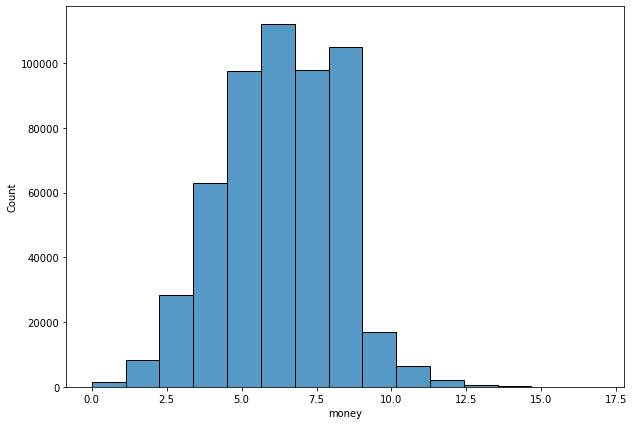

In [23]:
researh(test_group.groupby('user_id').agg('sum'), 'money')

Видно что есть ассимтерия, но в целом распределение похоже на нормальное.

Контрольная группа

Базовые метрики
count   539,991.0
mean          5.8
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    55576
5.0    54557
4.0    42771
5.0    37251
7.0    37051
Name: money, dtype: int64
------------------------------------
Эксцесс  0.006912261917506601
Ассиметрия  0.22888980004466286


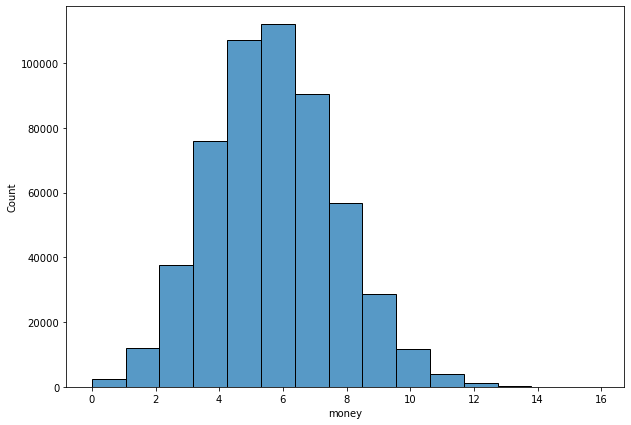

In [24]:
researh(control_group.groupby('user_id').agg('sum'), 'money')

Теперь найдем  ARPU и ARPPU 

In [25]:
# найдем суммы платежей для каждой группы

print('Сумма платежей тестовой группы - ', test_group_sum := test_group.money.sum())
print('Сумма платежей контрольной группы - ', control_group_sum := control_group.money.sum())

Сумма платежей тестовой группы -  3323389.1799999946
Сумма платежей контрольной группы -  3147865.7900000024


In [26]:
# найдем ARPU

ARPU_test = test_group_sum / test_group.drop_duplicates('user_id').count()[0]
ARPU_control = control_group_sum / control_group.drop_duplicates('user_id').count()[0]
print('ARPU тестовой группы - ', ARPU_test, '\n', 'ARPU контрольной группы - ', ARPU_control)

ARPU тестовой группы -  6.162275602990467 
 ARPU контрольной группы -  5.829478250563439


In [27]:
# также найдем их доверительные интервалы возьмем доверительную вероятность 95%

def confidence(df, column, alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval

In [28]:
test_confidence = confidence(test_group.groupby('user_id').agg('sum'), 'money')
print('Доверительный интервал тестовой группы', test_confidence)
control_confidence = confidence(control_group.groupby('user_id').agg('sum'), 'money')
print('Доверительный интервал контрольной группы', control_confidence)

Доверительный интервал тестовой группы (2.417077142534608, 9.907474063461883)
Доверительный интервал контрольной группы (2.1572457079550493, 9.501710793182074)


Различия не так уж и велики, но все таки у тестовой группы ARPU больше. Однако интервалы пересекаются почти на всю длину.

In [29]:
print('ARPU тестовой группы больше контрольной на ', round((ARPU_test - ARPU_control) / ARPU_control * 100, 1), ' %')

ARPU тестовой группы больше контрольной на  5.7  %


Теперь найдем ARPPU для этого сначала отделим платящих игроков

In [30]:
df = test_group.groupby('user_id').agg('sum').reset_index()
test_group_paying = df[df['money'] > 0]
df = control_group.groupby('user_id').agg('sum').reset_index()
control_group_paying = df[df['money'] > 0]

In [31]:
test_group.groupby('user_id').agg('sum').reset_index()

,user_id,cheaters,money
0,0004MK-VW0O9L,0,5.0
1,0005S4-UEC6BE,0,6.0
2,0007I5-EWUD6O,0,6.9
3,000IF8-UU506H,0,6.9
4,000IX6-VZLBS1,0,10.9
...,...,...,...
539307,ZZZIS2-9EYJF3,0,4.0
539308,ZZZONB-1W7QEW,0,7.0
539309,ZZZPEX-P2T8BH,0,7.0
539310,ZZZTEN-0QGZ3X,0,6.0


Базовые метрики
count   539,236.0
mean          6.2
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          16.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    55860
5.0    49457
7.0    40198
4.0    36292
6.9    35217
Name: money, dtype: int64
------------------------------------
Эксцесс  0.01948786963720961
Ассиметрия  0.24104777717750522


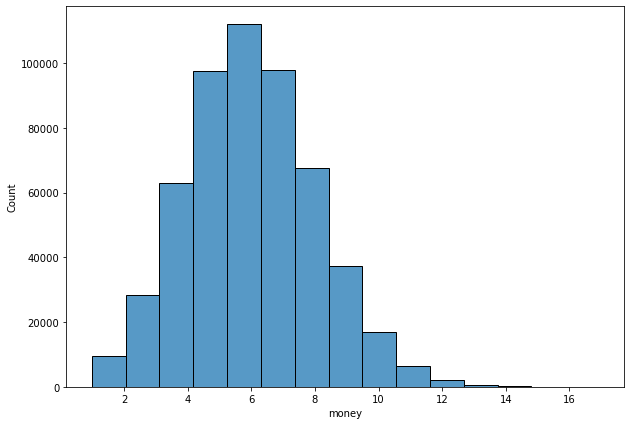

In [32]:
researh(test_group_paying, 'money')

Базовые метрики
count   539,840.0
mean          5.8
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    55576
5.0    54557
4.0    42771
5.0    37251
7.0    37051
Name: money, dtype: int64
------------------------------------
Эксцесс  -0.004748696740484171
Ассиметрия  0.23563197648757012


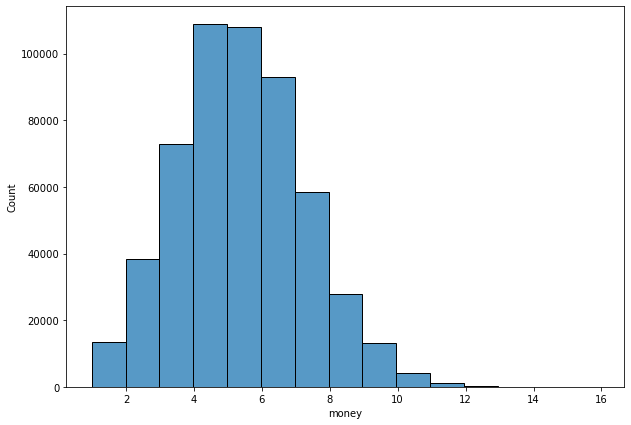

In [33]:
researh(control_group_paying, 'money')

In [34]:
# найдем ARPPU 

ARPPU_test = test_group_sum / test_group_paying.drop_duplicates('user_id').count()[0]
ARPPU_control = control_group_sum / control_group_paying.drop_duplicates('user_id').count()[0]
print('ARPPU тестовой группы - ', ARPPU_test, '\n', 'ARPPU контрольной группы - ', ARPPU_control)

ARPPU тестовой группы -  6.163144115007149 
 ARPPU контрольной группы -  5.831108828541795


In [35]:
test_paying_confidence = confidence(test_group_paying.groupby('user_id').agg('sum'), 'money')
print('Доверительный интервал тестовой группы', test_paying_confidence)
control_paying_confidence = confidence(control_group_paying.groupby('user_id').agg('sum'), 'money')
print('Доверительный интервал контрольной группы', control_paying_confidence)

Доверительный интервал тестовой группы (2.420427728875802, 9.905860501154054)
Доверительный интервал контрольной группы (2.163338538245194, 9.498879118848642)


In [36]:
print('ARPPU тестовой группы больше контрольной на ', round((ARPPU_test - ARPPU_control) / ARPPU_control * 100, 1), ' %')

ARPPU тестовой группы больше контрольной на  5.7  %


Интервалы пересекаются на обоих метриках, это говорит о случайности результатов,но результат от акции есть.

In [37]:
# проверим те же метрики для групп разных платформ.

test_group_PC = platforms[platforms['platform'] == 'PC'].merge(test_group, on = 'user_id')
test_group_PS4 = platforms[platforms['platform'] == 'PS4'].merge(test_group, on = 'user_id')
test_group_Xbox = platforms[platforms['platform'] == 'XBox'].merge(test_group, on = 'user_id')
control_group_PC = platforms[platforms['platform'] == 'PC'].merge(control_group, on = 'user_id')
control_group_PS4 = platforms[platforms['platform'] == 'PS4'].merge(control_group, on = 'user_id')
control_group_Xbox = platforms[platforms['platform'] == 'XBox'].merge(control_group, on = 'user_id')

In [38]:
# создадим немного более удобную функцию исследования

def all_research(df, column = 'money', alpha = 0.95):
    df_all = df.groupby('user_id').agg('sum').reset_index()
    print("Базовые метрики - все игроки")
    print(df_all[column].describe())
    print('Медиана - ', df_all[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df_all[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df_all[column]))
    print("Ассиметрия ", skew(df_all[column]))
    
    
    
    print('Сумма', df_all[column].sum())
    ARPU = df_all[column].sum() / df_all.drop_duplicates('user_id').count()[0]
    print('ARPU - ', ARPU)
    
    interval = stats.norm.interval(alpha, loc=df_all[column].mean(), scale=df_all[column].std())
    print('Доверительный интервал средней для всех', interval)
    print('-'* 20)
    print('-'* 20)
    
    dfs = df.groupby('user_id').agg('sum').reset_index()
    df_p = dfs[dfs['money'] > 0]
    
    print("Базовые метрики - платящие игроки")
    print(df_p[column].describe())
    print('Медиана - ', df_p[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df_p[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df_p[column]))
    print("Ассиметрия ", skew(df_p[column]))
    
    
    
    ARPPU = df_p[column].sum() / df_p.drop_duplicates('user_id').count()[0]
    
    print('ARPPU - ', ARPPU)
    
    interval = stats.norm.interval(alpha, loc=df_p[column].mean(), scale=df_p[column].std())
    print('Доверительный интервал средней для платящих', interval)
    
    
    all_plot = sb.histplot(df_all[column], color='yellow', bins=15);
    all_plot.set_title('Все игроки')
    plt.show()
    paying_plot = sb.histplot(df_p[column], bins=15, legend='Платящие игроки');
    paying_plot.set_title('Платящие игроки')

Базовые метрики - все игроки
count   179,820.0
mean          6.3
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.9
max          16.9
Name: money, dtype: float64
Медиана -  5.96
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18850
5.0    15995
7.0    13609
6.9    12138
4.0    11562
Name: money, dtype: int64
------------------------------------
Эксцесс  0.04797887632809106
Ассиметрия  0.24937041981274452
Сумма 1127299.88
ARPU -  6.269046157268379
Доверительный интервал средней для всех (2.487105299473276, 10.05098701502758)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,800.0
mean          6.3
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.9
max          16.9
Name: money, dtype: float64
Медиана -  5.96
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18850
5.0    15995
7.0    13609
6.9    12138


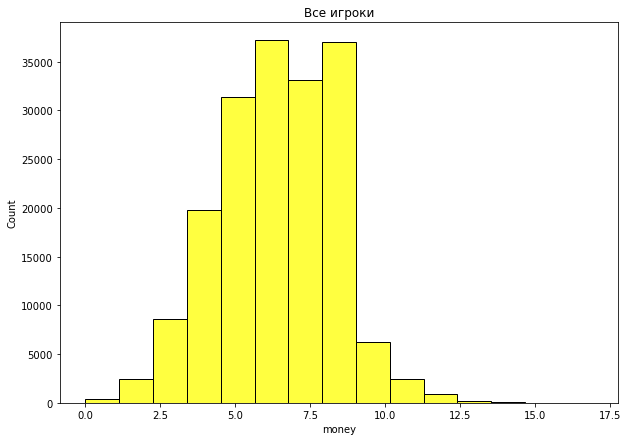

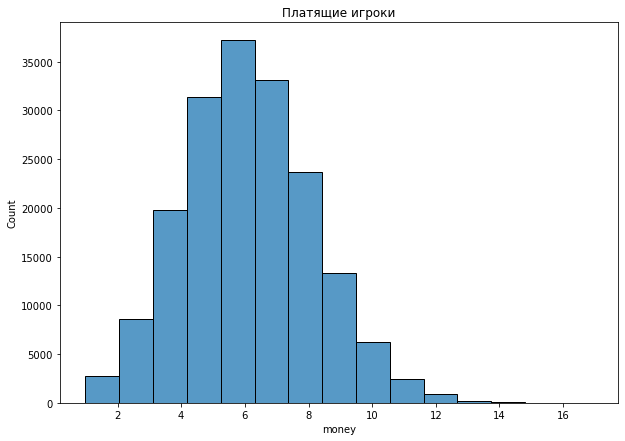

In [39]:
# описание тестовой группы игроков на ПК

all_research(test_group_PC)

Базовые метрики - все игроки
count   179,732.0
mean          5.6
std           1.8
min           0.0
25%           4.0
50%           5.9
75%           7.0
max          14.9
Name: money, dtype: float64
Медиана -  5.9399999999999995
------------------------------------
Самые популярные значения метрики, топ 5
5.0    19237
6.0    18918
4.0    15515
5.0    12858
7.0    11808
Name: money, dtype: int64
------------------------------------
Эксцесс  0.007294703110581668
Ассиметрия  0.20938340950020856
Сумма 1014803.06
ARPU -  5.6462013442236225
Доверительный интервал средней для всех (2.0852347204284074, 9.207167967987086)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,665.0
mean          5.6
std           1.8
min           1.0
25%           4.0
50%           5.9
75%           7.0
max          14.9
Name: money, dtype: float64
Медиана -  5.9399999999999995
------------------------------------
Самые популярные значения метрики, топ 5
5.0    19237
6.0    1

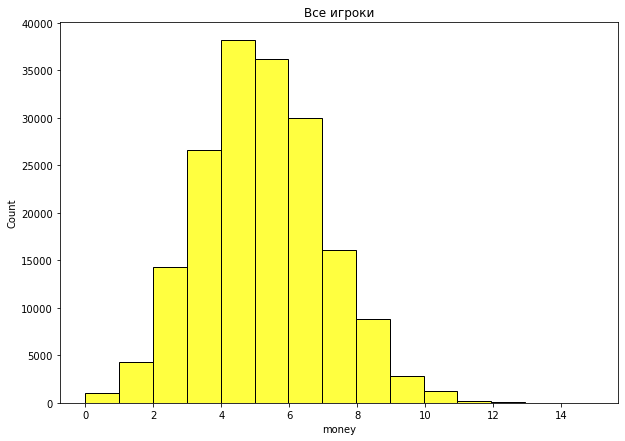

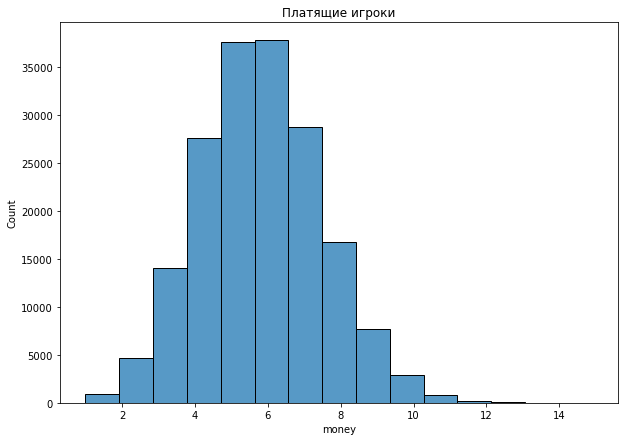

In [40]:
# описание контрольной грппы игроков на ПК

all_research(control_group_PC)

ARPU и ARPPU также выше у тестовой группы для игроков на ПК

Базовые метрики - все игроки
count   179,415.0
mean          6.1
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18512
5.0    16961
7.0    13321
4.0    12532
5.0    11722
Name: money, dtype: int64
------------------------------------
Эксцесс  0.005903475589768448
Ассиметрия  0.21822758720072233
Сумма 1091719.2100000002
ARPU -  6.08488259064181
Доверительный интервал средней для всех (2.3902870056128545, 9.779478175636244)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,386.0
mean          6.1
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18512
5.0    16961
7.0    13321
4.0 

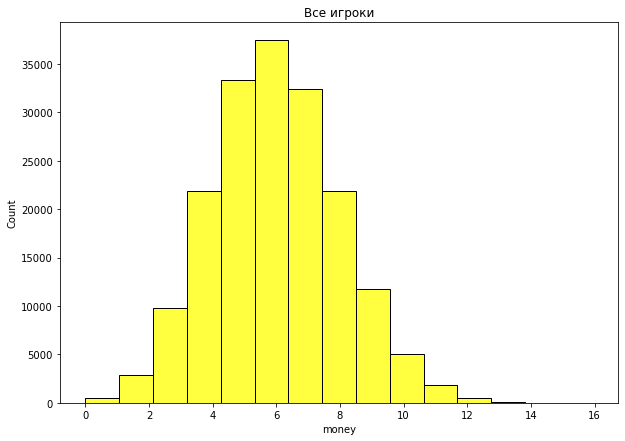

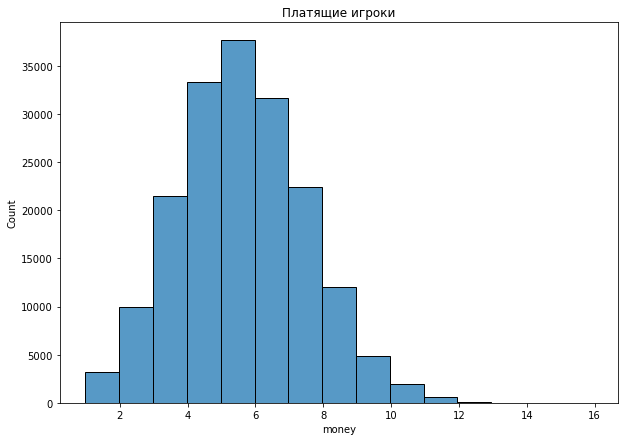

In [41]:
# описание тестовой группы игроков на ПС4

all_research(test_group_PS4)

Базовые метрики - все игроки
count   179,804.0
mean          5.7
std           1.9
min           0.0
25%           4.0
50%           6.0
75%           7.0
max          14.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
5.0    18389
6.0    18113
4.0    14827
5.0    12557
7.0    11980
Name: money, dtype: int64
------------------------------------
Эксцесс  -0.03658336978708654
Ассиметрия  0.21783101352028067
Сумма 1031651.8699999999
ARPU -  5.73764693777669
Доверительный интервал средней для всех (2.0782611436421083, 9.397032731878994)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,747.0
mean          5.7
std           1.9
min           1.0
25%           4.0
50%           6.0
75%           7.0
max          14.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
5.0    18389
6.0    18113
4.0    14827
5.0 

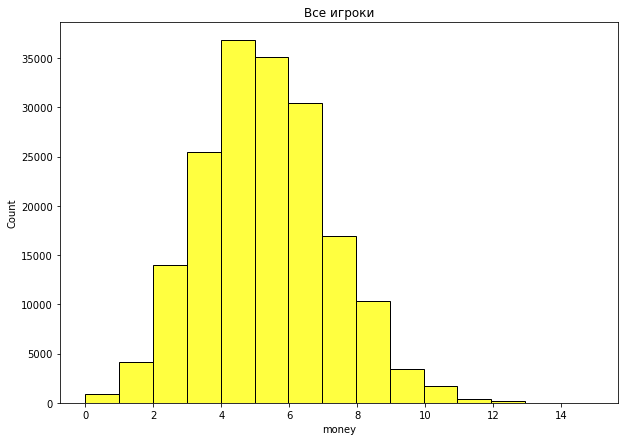

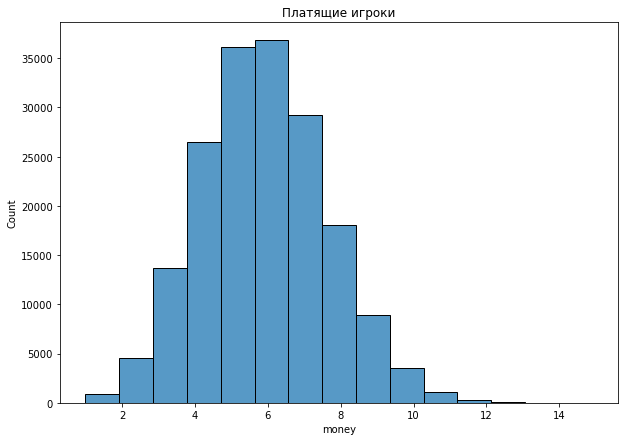

In [42]:
# описание контрольной группы игроков на ПС4
all_research(control_group_PS4)

Показатели ARPU ARPPU тестовой группы также больше контрольной, но при этом меньше чем у группы на игроков ПК

Базовые метрики - все игроки
count   180,077.0
mean          6.1
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18498
5.0    16501
7.0    13268
4.0    12198
5.0    11751
Name: money, dtype: int64
------------------------------------
Эксцесс  0.012458503010370325
Ассиметрия  0.23785999509845931
Сумма 1104370.09
ARPU -  6.1327659279086175
Доверительный интервал средней для всех (2.383687674723918, 9.881844181058247)
--------------------
--------------------
Базовые метрики - платящие игроки
count   180,050.0
mean          6.1
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18498
5.0    16501
7.0    13268
4.0    1219

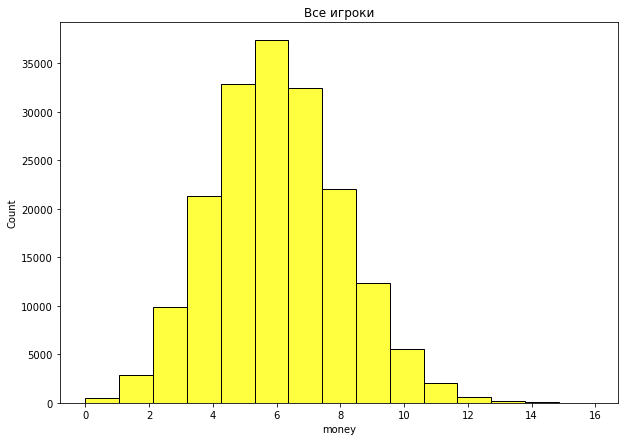

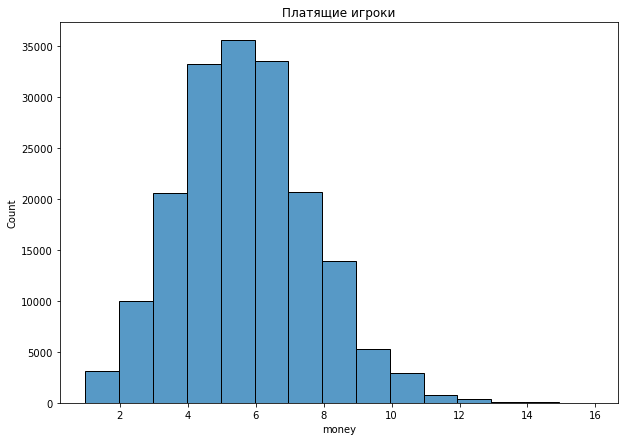

In [43]:
# описание тестовой группы игроков на иксбокс

all_research(test_group_Xbox)

Базовые метрики - все игроки
count   180,455.0
mean          6.1
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18545
5.0    16931
7.0    13263
4.0    12429
5.0    11836
Name: money, dtype: int64
------------------------------------
Эксцесс  0.007546259405377231
Ассиметрия  0.23325578640234226
Сумма 1101410.8599999999
ARPU -  6.103520877781164
Доверительный интервал средней для всех (2.371017420681194, 9.836024334846265)
--------------------
--------------------
Базовые метрики - платящие игроки
count   180,428.0
mean          6.1
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18545
5.0    16931
7.0    13263
4.0 

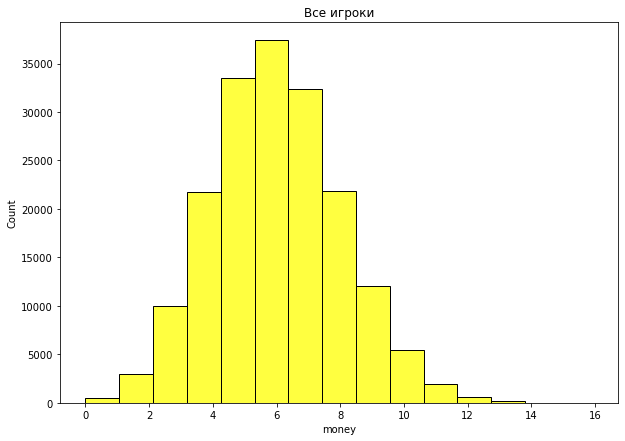

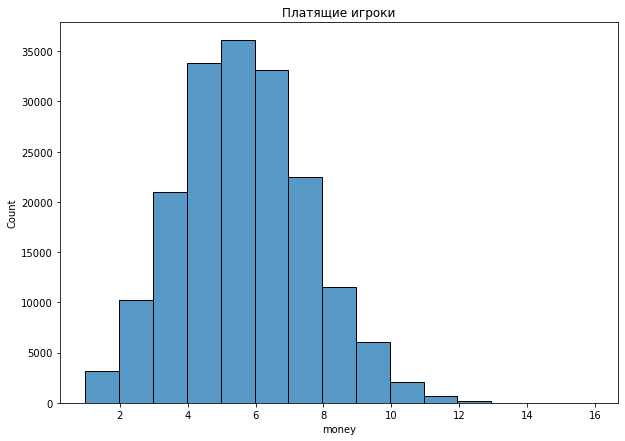

In [44]:
# описание контрольной группы игроков на иксбокс

all_research(control_group_Xbox)

На игроков на иксбокс акция не подействовала практически никак, наиболее сильный эффект от акции был на игроках на ПК, послабее для игроков на ПС4 и практически никакой для игроков на иксбокс. Имеет смысл проводить акцию для игроков на ПК и ПС4 для всех игроков. Также в

### Раздел 5. Отчёт

In [45]:
# Добавим метрики ARSU, ARSPU которые представляют из себя коэффициент суммарная трата за период / кол-во игроков(платящих игроков)
# изменим наименования метрик, и увеличим разбиение в графиках

def all_research(df, column = 'money', alpha = 0.95):
    df_all = df.groupby('user_id').agg('sum').reset_index()
    print("Базовые метрики - все игроки")
    print(df_all[column].describe())
    print('Медиана - ', df_all[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df_all[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df_all[column]))
    print("Ассиметрия ", skew(df_all[column]))
    
    
    
    print('Сумма', df_all[column].sum())
    ARSU = df_all[column].sum() / df_all.drop_duplicates('user_id').count()[0]
    print('ARSU - ', ARSU)
    
    interval = stats.norm.interval(alpha, loc=df_all[column].mean(), scale=df_all[column].std())
    print('Доверительный интервал средней для всех', interval)
    print('-'* 20)
    print('-'* 20)
    
    dfs = df.groupby('user_id').agg('sum').reset_index()
    df_p = dfs[dfs['money'] > 0]
    
    print("Базовые метрики - платящие игроки")
    print(df_p[column].describe())
    print('Медиана - ', df_p[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df_p[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df_p[column]))
    print("Ассиметрия ", skew(df_p[column]))
    
    
    
    ARSPU = df_p[column].sum() / df_p.drop_duplicates('user_id').count()[0]
    
    print('ARSPU - ', ARSPU)
    
    interval = stats.norm.interval(alpha, loc=df_p[column].mean(), scale=df_p[column].std())
    print('Доверительный интервал средней для платящих', interval)
    
    
    all_plot = sb.histplot(df_all[column], color='yellow', bins=40);
    all_plot.set_title('Все игроки')
    plt.show()
    paying_plot = sb.histplot(df_p[column], bins=40, legend='Платящие игроки');
    paying_plot.set_title('Платящие игроки')

In [46]:
# добавим колонку с тратой валюты

test_group = test_group.merge(cash, on=['user_id', 'date'])
control_group = control_group.merge(cash, on=['user_id', 'date'])

Базовые метрики - все игроки
count   539,312.0
mean      6,229.6
std       1,411.4
min         100.0
25%       5,300.0
50%       6,250.0
75%       7,200.0
max      13,250.0
Name: cash, dtype: float64
Медиана -  6250.0
------------------------------------
Самые популярные значения метрики, топ 5
6400    7737
6200    7695
6100    7660
6450    7631
6000    7605
Name: cash, dtype: int64
------------------------------------
Эксцесс  0.006093711613086583
Ассиметрия  0.010217085257937361
Сумма 3359696050
ARSU -  6229.596319013855
Доверительный интервал средней для всех (3463.289304234267, 8995.903333793442)
--------------------
--------------------
Базовые метрики - платящие игроки
count   539,236.0
mean      6,230.0
std       1,411.0
min         100.0
25%       5,300.0
50%       6,250.0
75%       7,200.0
max      13,250.0
Name: cash, dtype: float64
Медиана -  6250.0
------------------------------------
Самые популярные значения метрики, топ 5
6400    7737
6200    7695
6100    7660
6450    76

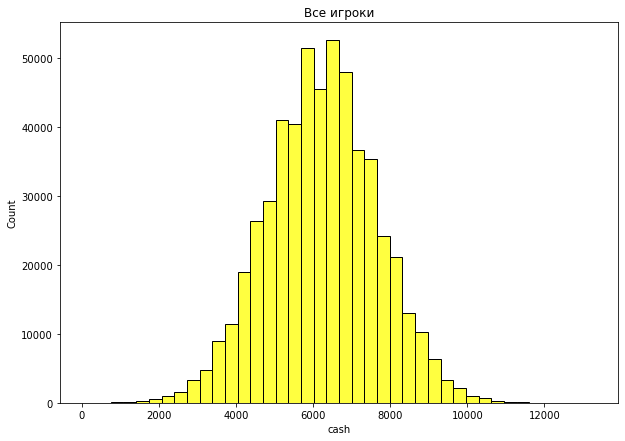

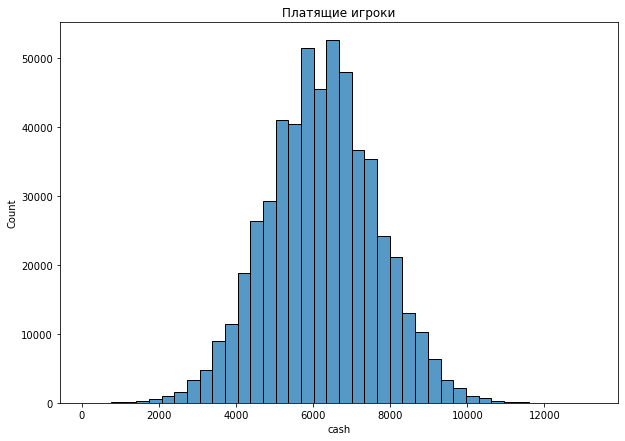

In [47]:
# используем нашу функцию all_research, но зададим колонку явно. Исследуется тестовая группа

all_research(test_group, 'cash')

Базовые метрики - все игроки
count   539,991.0
mean      5,800.7
std       1,347.1
min          50.0
25%       4,900.0
50%       5,800.0
75%       6,700.0
max      12,300.0
Name: cash, dtype: float64
Медиана -  5800.0
------------------------------------
Самые популярные значения метрики, топ 5
5700    8234
5850    8176
6050    8060
5750    8033
5600    8021
Name: cash, dtype: int64
------------------------------------
Эксцесс  0.03639547405548127
Ассиметрия  0.044479811298419145
Сумма 3132328700
ARSU -  5800.705382126739
Доверительный интервал средней для всех (3160.4640590387303, 8440.946705214748)
--------------------
--------------------
Базовые метрики - платящие игроки
count   539,840.0
mean      5,801.4
std       1,346.5
min          50.0
25%       4,900.0
50%       5,800.0
75%       6,700.0
max      12,300.0
Name: cash, dtype: float64
Медиана -  5800.0
------------------------------------
Самые популярные значения метрики, топ 5
5700    8234
5850    8176
6050    8060
5750    80

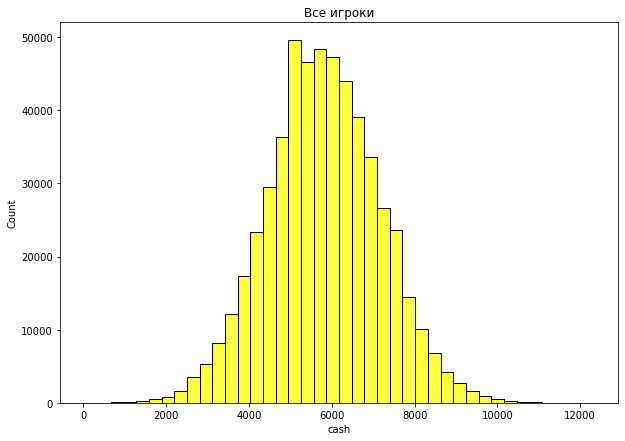

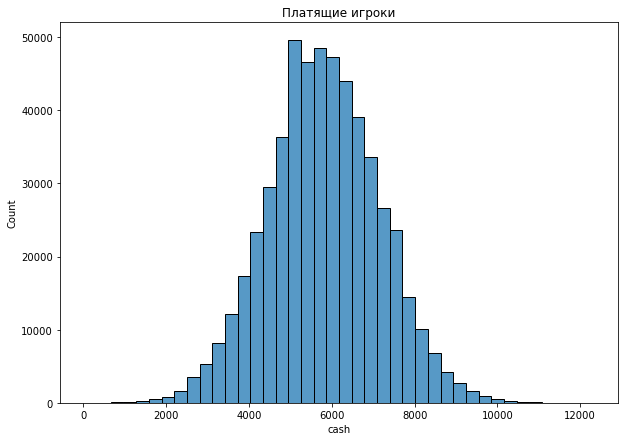

In [48]:
# контрольная группа

all_research(control_group, 'cash')

In [49]:
# добавим столбец платежей в существующие датафреймы

test_group_PC = test_group_PC.merge(cash, on = ['user_id', 'date'])
test_group_PS4 = test_group_PS4.merge(cash, on = ['user_id', 'date'])
test_group_Xbox = test_group_Xbox.merge(cash, on = ['user_id', 'date'])
control_group_PC = control_group_PC.merge(cash, on = ['user_id', 'date'])
control_group_PS4 = control_group_PS4.merge(cash, on = ['user_id', 'date'])
control_group_Xbox = control_group_Xbox.merge(cash, on = ['user_id', 'date'])

Базовые метрики - все игроки
count   179,820.0
mean      6,381.7
std       1,456.3
min         100.0
25%       5,400.0
50%       6,400.0
75%       7,350.0
max      12,700.0
Name: cash, dtype: float64
Медиана -  6400.0
------------------------------------
Самые популярные значения метрики, топ 5
6400    2527
6450    2502
6650    2502
6100    2476
6200    2453
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.00691655344235631
Ассиметрия  -0.004635102042471981
Сумма 1147565500
ARSU -  6381.745634523412
Доверительный интервал средней для всех (3527.490304225572, 9236.000964821253)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,800.0
mean      6,382.1
std       1,456.0
min         100.0
25%       5,400.0
50%       6,400.0
75%       7,350.0
max      12,700.0
Name: cash, dtype: float64
Медиана -  6400.0
------------------------------------
Самые популярные значения метрики, топ 5
6400    2527
6450    2502
6650    2502
6100    2

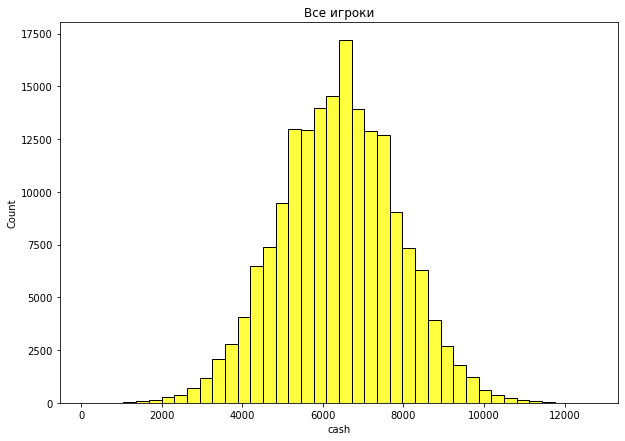

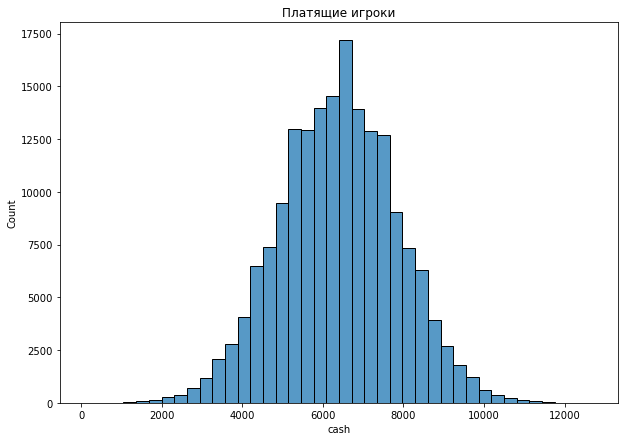

In [50]:
# Исследуем тестовую группу игроков на ПК

all_research(test_group_PC, 'cash')

Базовые метрики - все игроки
count   179,732.0
mean      5,587.1
std       1,238.5
min          50.0
25%       4,750.0
50%       5,600.0
75%       6,400.0
max      11,350.0
Name: cash, dtype: float64
Медиана -  5600.0
------------------------------------
Самые популярные значения метрики, топ 5
5550    2964
5700    2961
5600    2954
5500    2922
5650    2882
Name: cash, dtype: int64
------------------------------------
Эксцесс  0.02336671947937674
Ассиметрия  -0.006913814380671639
Сумма 1004181050
ARSU -  5587.102185476153
Доверительный интервал средней для всех (3159.7836793857646, 8014.420691566542)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,665.0
mean      5,588.0
std       1,237.8
min          50.0
25%       4,750.0
50%       5,600.0
75%       6,400.0
max      11,350.0
Name: cash, dtype: float64
Медиана -  5600.0
------------------------------------
Самые популярные значения метрики, топ 5
5550    2964
5700    2961
5600    2954
5500    2

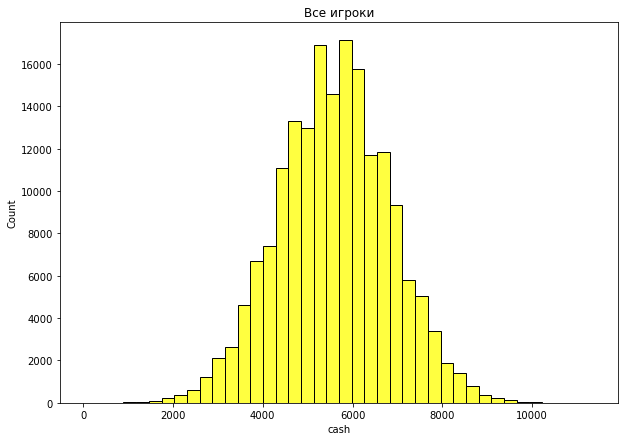

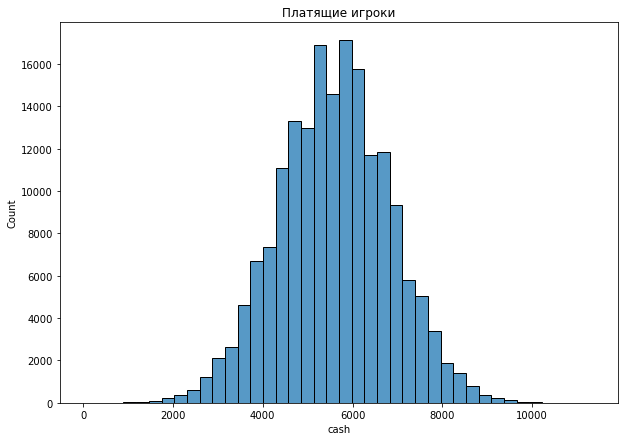

In [51]:
# контрольная группа игроков на ПК

all_research(control_group_PC, 'cash')

Базовые метрики - все игроки
count   179,415.0
mean      6,130.5
std       1,362.2
min         100.0
25%       5,200.0
50%       6,150.0
75%       7,050.0
max      13,250.0
Name: cash, dtype: float64
Медиана -  6150.0
------------------------------------
Самые популярные значения метрики, топ 5
6100    2666
6200    2658
6000    2655
5800    2644
6050    2636
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.0022666108463544887
Ассиметрия  -0.008803924709465174
Сумма 1099902450
ARSU -  6130.4932697934955
Доверительный интервал средней для всех (3460.5664381068054, 8800.420101480186)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,386.0
mean      6,130.9
std       1,361.9
min         100.0
25%       5,200.0
50%       6,150.0
75%       7,050.0
max      13,250.0
Name: cash, dtype: float64
Медиана -  6150.0
------------------------------------
Самые популярные значения метрики, топ 5
6100    2666
6200    2658
6000    2655
5800 

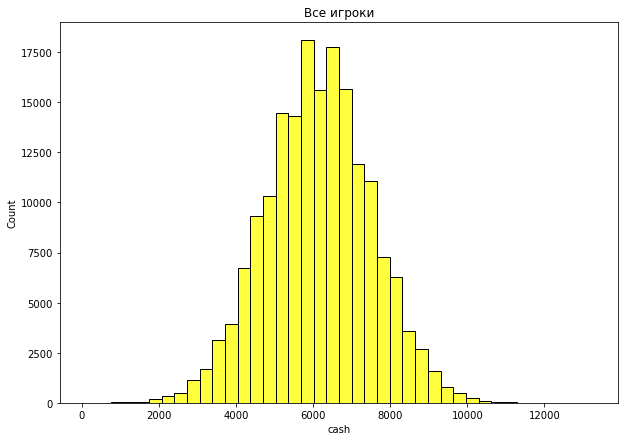

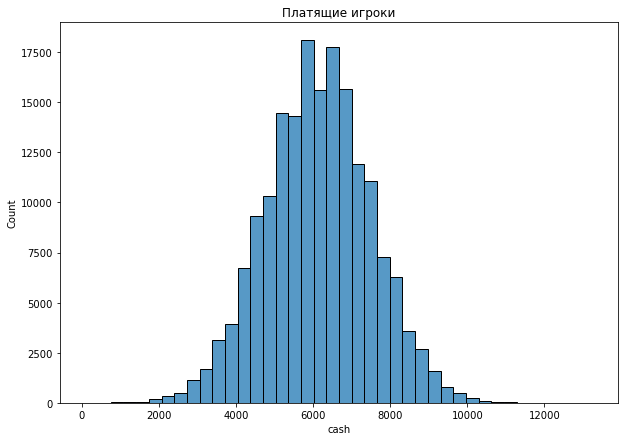

In [52]:
# Тестовая группа игроков на ПС4

all_research(test_group_PS4, 'cash')

Базовые метрики - все игроки
count   179,804.0
mean      5,681.9
std       1,334.4
min          50.0
25%       4,800.0
50%       5,700.0
75%       6,600.0
max      11,600.0
Name: cash, dtype: float64
Медиана -  5700.0
------------------------------------
Самые популярные значения метрики, топ 5
5700    2768
5850    2748
5500    2721
5750    2716
5600    2704
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.012463456882148893
Ассиметрия  -0.009713017986440616
Сумма 1021634850
ARSU -  5681.936163822829
Доверительный интервал средней для всех (3066.57092390516, 8297.3014037405)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,747.0
mean      5,682.7
std       1,333.8
min          50.0
25%       4,800.0
50%       5,700.0
75%       6,600.0
max      11,600.0
Name: cash, dtype: float64
Медиана -  5700.0
------------------------------------
Самые популярные значения метрики, топ 5
5700    2768
5850    2748
5500    2721
5750    271

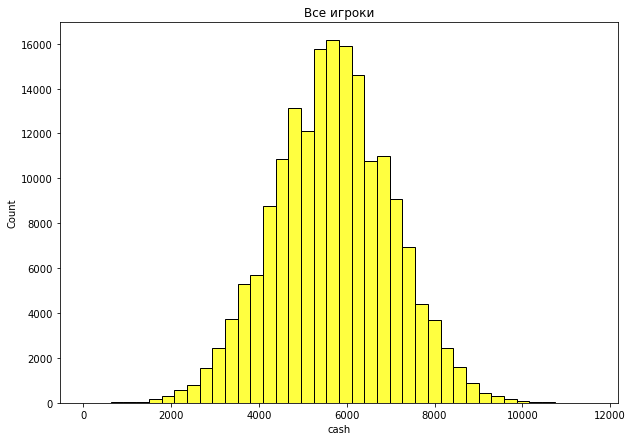

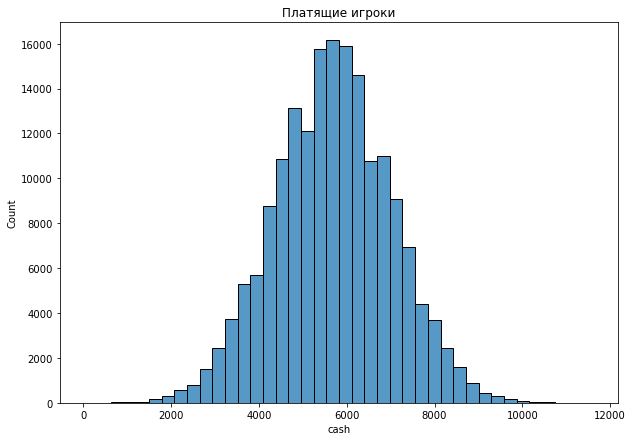

In [53]:
# Контрольная группа игроков на ПС4

all_research(control_group_PS4, 'cash')

Базовые метрики - все игроки
count   180,077.0
mean      6,176.4
std       1,401.3
min         150.0
25%       5,250.0
50%       6,200.0
75%       7,100.0
max      12,450.0
Name: cash, dtype: float64
Медиана -  6200.0
------------------------------------
Самые популярные значения метрики, топ 5
6300    2637
6350    2615
6400    2606
5900    2594
6000    2589
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.0007575675274424931
Ассиметрия  0.006007650551653336
Сумма 1112228100
ARSU -  6176.402872104711
Доверительный интервал средней для всех (3429.8260479286673, 8922.979696280754)
--------------------
--------------------
Базовые метрики - платящие игроки
count   180,050.0
mean      6,176.8
std       1,400.9
min         150.0
25%       5,250.0
50%       6,200.0
75%       7,100.0
max      12,450.0
Name: cash, dtype: float64
Медиана -  6200.0
------------------------------------
Самые популярные значения метрики, топ 5
6300    2637
6350    2615
6400    2606
5900   

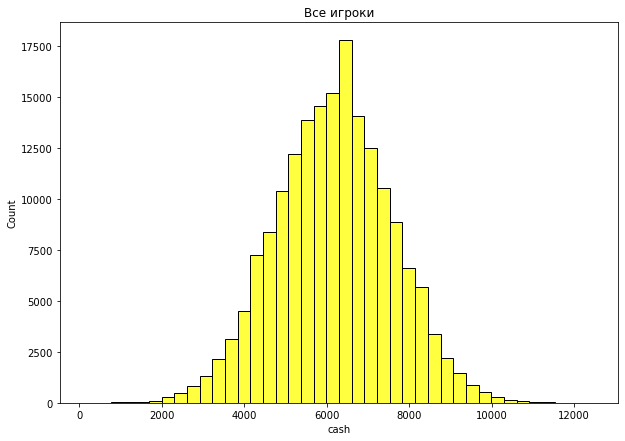

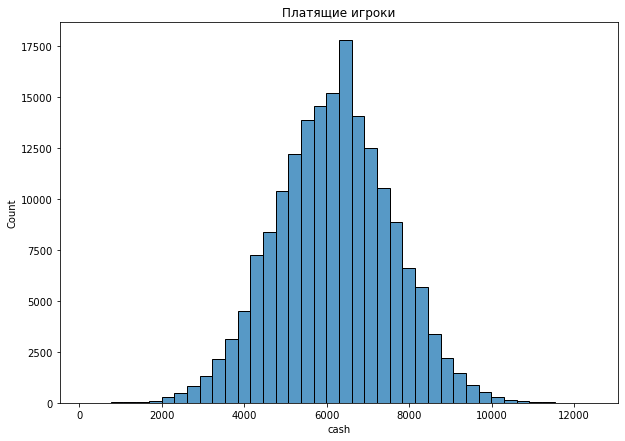

In [54]:
# Тестовая группа игроков на иксбокс

all_research(test_group_Xbox, 'cash')

Базовые метрики - все игроки
count   180,455.0
mean      6,131.8
std       1,399.7
min         250.0
25%       5,200.0
50%       6,150.0
75%       7,050.0
max      12,300.0
Name: cash, dtype: float64
Медиана -  6150.0
------------------------------------
Самые популярные значения метрики, топ 5
6050    2649
6350    2598
5900    2592
6100    2592
6000    2575
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.003319192521404002
Ассиметрия  0.0005730065121141638
Сумма 1106512800
ARSU -  6131.7935219306755
Доверительный интервал средней для всех (3388.3958264174894, 8875.191217443862)
--------------------
--------------------
Базовые метрики - платящие игроки
count   180,428.0
mean      6,132.2
std       1,399.3
min         250.0
25%       5,200.0
50%       6,150.0
75%       7,050.0
max      12,300.0
Name: cash, dtype: float64
Медиана -  6150.0
------------------------------------
Самые популярные значения метрики, топ 5
6050    2649
6350    2598
5900    2592
6100  

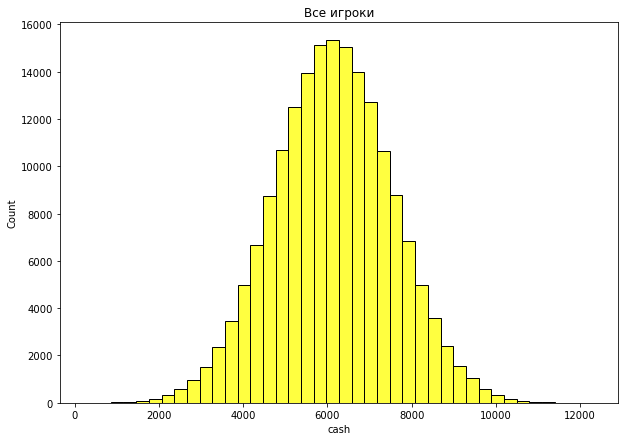

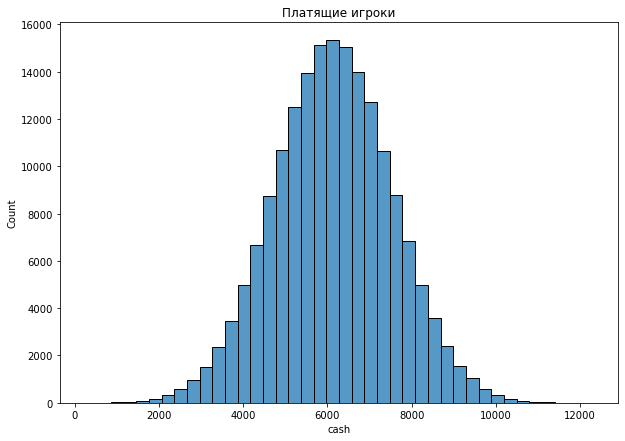

In [55]:
# Контрольная группа игроков на иксбокс

all_research(control_group_Xbox, 'cash')

In [56]:
# подготовим датафрейм который позже преобразуем в csv для PowerBI, в нем должны быть столбцы с нашими метриками по дням

powerbi_test = test_group.groupby('date').agg('sum')

In [57]:
powerbi_test['users'] = test_group.groupby('date').agg('count')['user_id'][1]

In [58]:
# так как во все дни количесвто платящих и не платящих одинаково, в столбел платящих игроков можно ввести константу, в противном случае можно сгруппировать по дате с количеством игроков и добавить столбец с игроками в наш датафрейм

df = test_group.groupby('user_id').agg('sum').reset_index().drop(columns='cheaters')
df = df[df['money'] > 0]
df = pd.DataFrame(df.drop(columns=['money', 'cash']).merge(money, on = 'user_id').merge(cash, on = ['user_id', 'date'])\
.groupby('date').agg('count')['user_id'].reset_index())


In [59]:
# Переименуем столбец

df.rename(columns={'user_id' : 'paying_users'}, inplace=True)

In [60]:
# соединим

powerbi_test = powerbi_test.merge(df, on='date')

In [61]:
# добавим метрики по дням

powerbi_test['ARPU'] = powerbi_test['money'] / powerbi_test['users']

In [62]:
powerbi_test['ARPPU'] = powerbi_test['money'] / powerbi_test['paying_users']
powerbi_test['ARSU'] = powerbi_test['cash'] / powerbi_test['users']
powerbi_test['ARSPU'] = powerbi_test['cash'] / powerbi_test['paying_users']

In [63]:
# удалим ненужнй столбец

powerbi_test.drop(columns='cheaters', inplace=True)

In [64]:
powerbi_test

,date,money,cash,users,paying_users,ARPU,ARPPU,ARSU,ARSPU
0,2021-07-10,"410,341.9",439980100,539312,539236,0.8,0.8,815.8,815.9
1,2021-07-11,"410,937.9",440212450,539312,539236,0.8,0.8,816.2,816.4
2,2021-07-12,"409,077.7",437566350,539312,539236,0.8,0.8,811.3,811.5
3,2021-07-13,"400,947.8",428022700,539312,539236,0.7,0.7,793.6,793.8
4,2021-07-14,"383,022.8",402593600,539312,539236,0.7,0.7,746.5,746.6
5,2021-07-15,"353,538.5",356375500,539312,539236,0.7,0.7,660.8,660.9
6,2021-07-16,"314,611.7",290573050,539312,539236,0.6,0.6,538.8,538.9
7,2021-07-17,"640,910.7",564372300,539312,539236,1.2,1.2,"1,046.5","1,046.6"


Так как количество пользователей неизменно, а период прибыли теперь день, ARPU и остальные метрики занижены

In [65]:
# сохраним в csv

powerbi_test.to_csv('power_test.csv',index=False)

In [66]:
# повторим то же самое для контрольной группы

powerbi_control = control_group.groupby('date').agg('sum')
powerbi_control['users'] = control_group.groupby('date').agg('count')['user_id'][1]
df = control_group.groupby('user_id').agg('sum').reset_index().drop(columns='cheaters')
df = df[df['money'] > 0]
df = pd.DataFrame(df.drop(columns=['money', 'cash']).merge(money, on = 'user_id').merge(cash, on = ['user_id', 'date'])\
.groupby('date').agg('count')['user_id'].reset_index())
df.rename(columns={'user_id' : 'paying_users'}, inplace=True)
powerbi_control = powerbi_control.merge(df, on='date')
powerbi_control['ARPU'] = powerbi_control['money'] / powerbi_control['users']
powerbi_control['ARPPU'] = powerbi_control['money'] / powerbi_control['paying_users']
powerbi_control['ARSU'] = powerbi_control['cash'] / powerbi_control['users']
powerbi_control['ARSPU'] = powerbi_control['cash'] / powerbi_control['paying_users']
powerbi_control.drop(columns='cheaters', inplace=True)
powerbi_control

,date,money,cash,users,paying_users,ARPU,ARPPU,ARSU,ARSPU
0,2021-07-10,"393,870.2",414345600,539991,539840,0.7,0.7,767.3,767.5
1,2021-07-11,"392,476.6",413883550,539991,539840,0.7,0.7,766.5,766.7
2,2021-07-12,"390,787.8",411404650,539991,539840,0.7,0.7,761.9,762.1
3,2021-07-13,"382,743.8",401374950,539991,539840,0.7,0.7,743.3,743.5
4,2021-07-14,"364,514.4",376459800,539991,539840,0.7,0.7,697.2,697.4
5,2021-07-15,"335,543.7",331369100,539991,539840,0.6,0.6,613.7,613.8
6,2021-07-16,"299,028.2",269428450,539991,539840,0.6,0.6,498.9,499.1
7,2021-07-17,"588,901.1",514062600,539991,539840,1.1,1.1,952.0,952.2


In [67]:
# сохраним в csv

powerbi_control.to_csv('power_control.csv',index=False)

Теперь подготовим эксель файл для сводной таблицы ARPU по группам и платформам. Для этого нужна таблица с количеством игроков, их платформой, группой, и суммарным платежом за период.

In [50]:
excel = money.groupby('user_id').agg('sum').reset_index()\
.merge(platforms, on='user_id').merge(players, on='user_id')\
.drop(columns='cheaters')


In [51]:
df = excel.groupby(['platform', 'group']).agg('sum').reset_index()
df = df.merge(excel.groupby(['platform', 'group']).agg('count').reset_index()[['user_id', 'platform', 'group']], on=['platform', 'group'])

In [53]:
df.rename(columns={'user_id' : 'users'}, inplace=True)


In [55]:
df.to_excel('table.xlsx')